In [411]:
# This is a long process, so have it separate from the other pip installations.

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install -r requirements.txt

     ---------------------------------------- 9.1/9.1 MB 25.4 MB/s eta 0:00:00
     ---------------------------------------- 233.7/233.7 KB ? eta 0:00:00


In [706]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import tensorflow as tf
import datetime

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
#%matplotlib notebook

In [156]:
import seaborn as sn

def plot_correlation(df):

    fig, ax = plt.subplots(1, 1, figsize=(len(df.columns), len(df.columns)), dpi=100)
    sn.heatmap(df.corr(), annot=True, ax=ax)
    ax.set_title('Correlation Matrix')
    return plt.gcf()

In [782]:
def plot_history(history, title='Model'):
    fig, (loss, acc) = plt.subplots(2, 1, figsize=(6, 6), dpi=100)
    loss.plot(history['loss'], label='Training Loss')
    loss.plot(history['val_loss'], label='Validation Loss')
    loss.set_title(title + ' Loss Plots')
    loss.legend()
    
    acc.plot(history['accuracy'], label='Training Accuracy')
    acc.plot(history['val_accuracy'], label='Validation Accuracy')
    acc.set_title(title + ' Accuracy Plots')
    acc.legend()
    
    plt.show()

    #print(history.params)
    #print(history.history.keys())

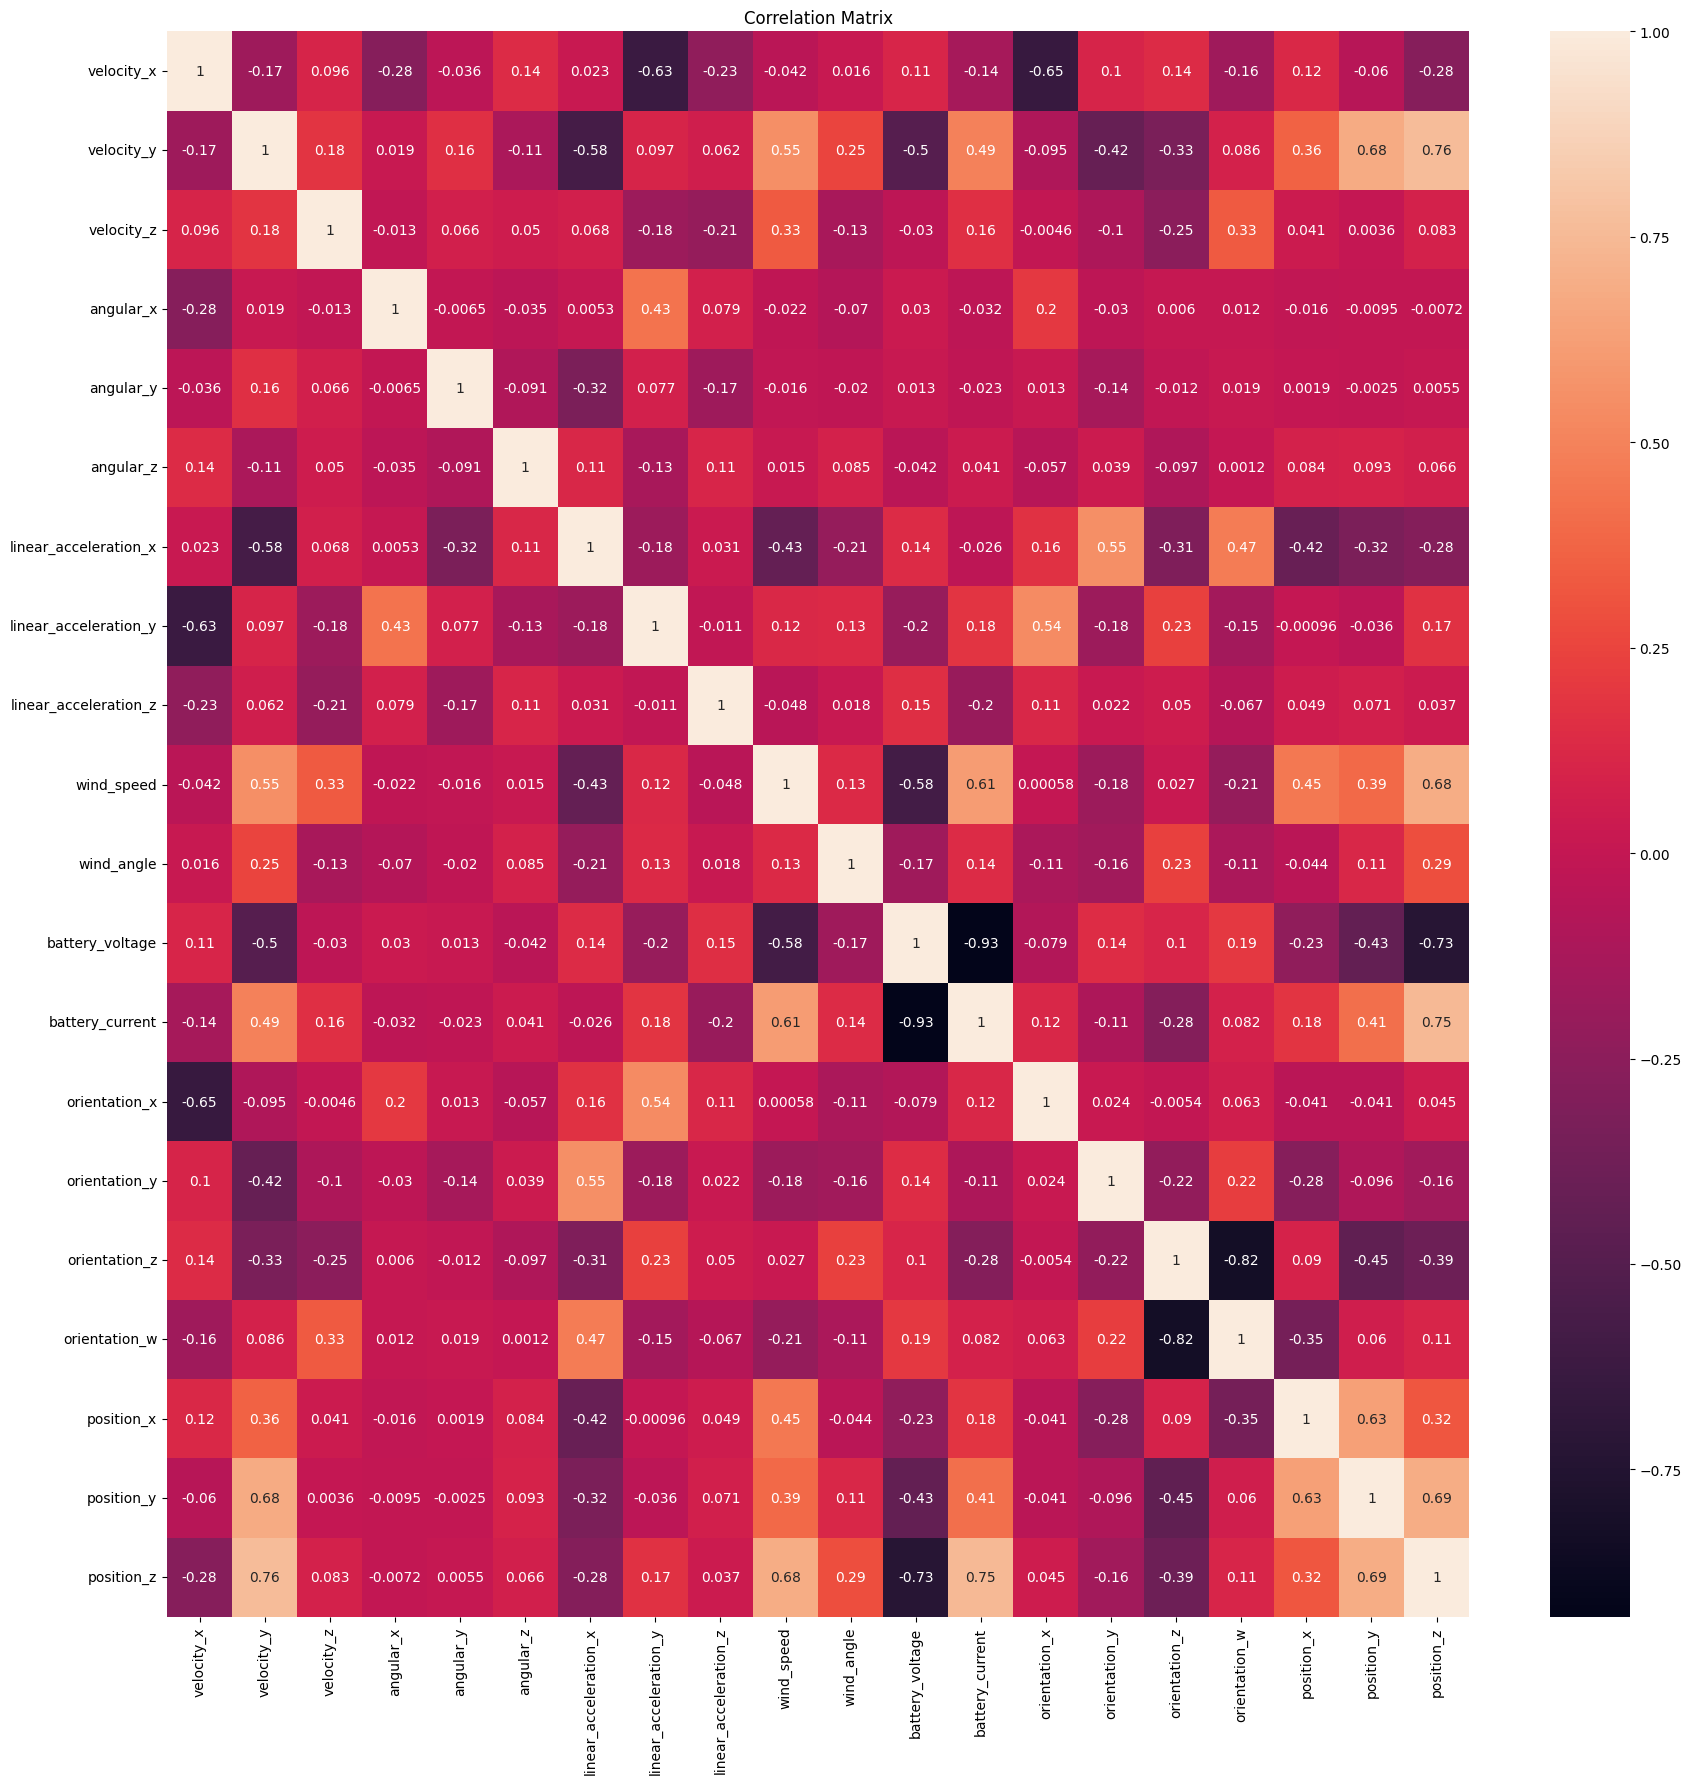

In [546]:
# Load Data
uav = pd.read_csv('uav_flight_data.csv')
# This should be the miminum information required, but for a single flight it does not do well
#fields = ['angular_x', 'angular_y', 'angular_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'position_z']
# Adding in the wind speed and battery information, the model performs much, much better.
#fields = ['angular_x', 'angular_y', 'angular_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'wind_speed', 'wind_angle', 'battery_voltage', 'battery_current', 'position_z']
# Now with everyone!  This produced a great plot!!!  There must be non-correlated (?) information between the accel and vel terms.
inputs = ['velocity_x', 'velocity_y', 'velocity_z', 'angular_x', 'angular_y', 'angular_z', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'wind_speed', 'wind_angle', 'battery_voltage', 'battery_current', 'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w']
outputs = ['position_x', 'position_y', 'position_z']

# TODO: Read the datetime from the parameters file
start = dt.datetime(year=2015,month=1,day=1)
uav['time'] = uav['time'] + start.timestamp()
uav["time"] = pd.to_datetime(uav["time"], unit='s')

uav = uav[['time', *inputs, *outputs]]

# Do I still need this for this clean dataset?
uav.fillna(uav.bfill())

# Extract the training and test datasets
train = uav[:int(len(uav)*0.8)]
test = uav[int(len(uav)*0.8):]

corr = uav.corr()
'''
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
#selected_columns = uav.columns[columns]
print(columns)
'''

fig = plot_correlation(uav)

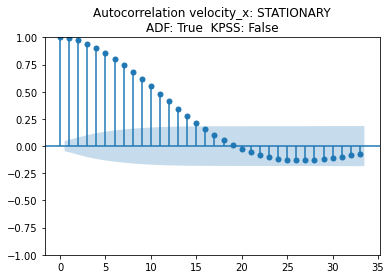

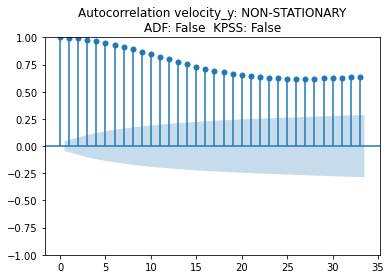

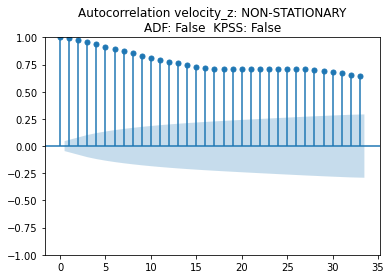

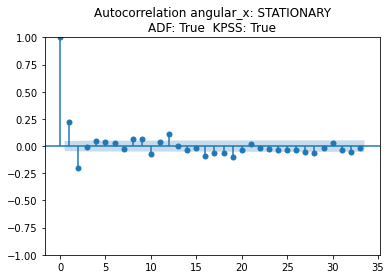

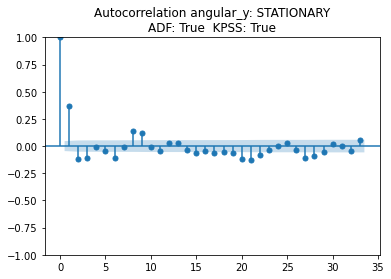

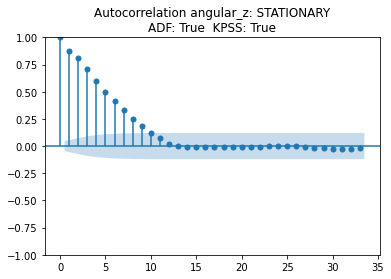

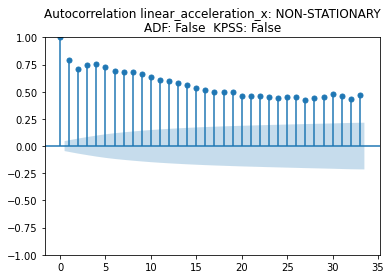

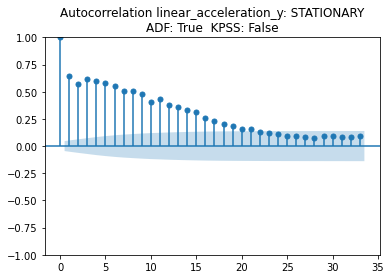

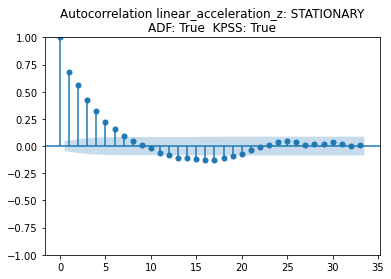

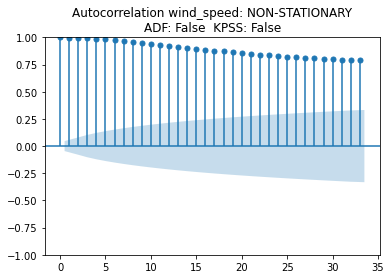

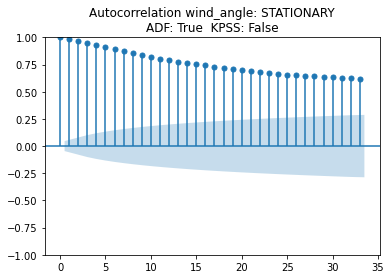

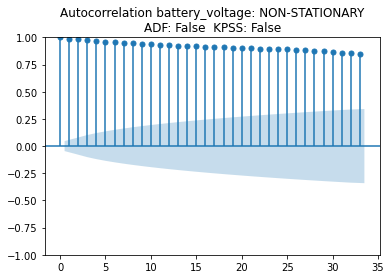

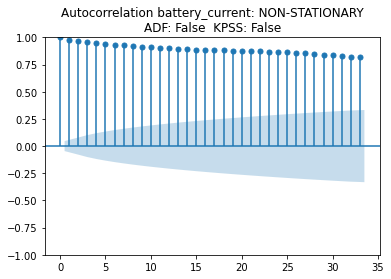

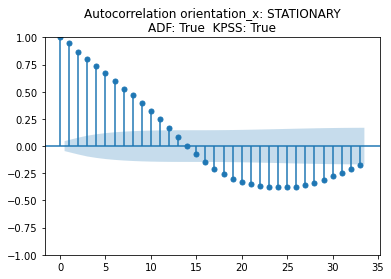

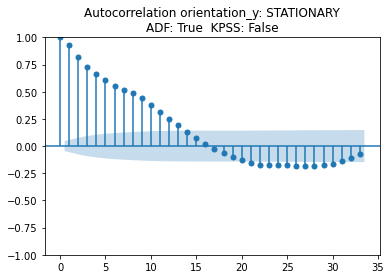

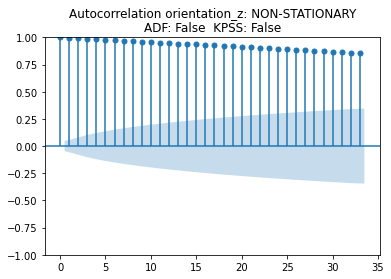

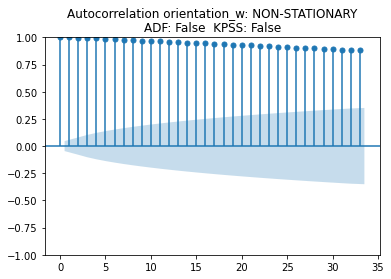

In [547]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

from pandas import read_csv
from statsmodels.tsa.stattools import adfuller, kpss

## Test the stationarity of a time series.  ADF is a 'Unit Root Test'
## https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

#inputs = ['wind_angle']
#inputs = ['velocity_z']
stationary = []

for field in inputs:
    title = f'Autocorrelation {field}: '
    ret_adf = adfuller(uav[field])
    ret_kpss = kpss(uav[field], regression='ct')

    pass_adf = ret_adf[1] <= 0.05 and ret_adf[0] < min(result[4].values())
    pass_kpss = ret_kpss[1] > 0.05

    if pass_adf or pass_kpss:
        title += f'STATIONARY\nADF: {pass_adf}  KPSS: {pass_kpss}'
        stationary.append(field)
    else:
        title += f'NON-STATIONARY\nADF: {pass_adf}  KPSS: {pass_kpss}'

    if False:
        print(f'Series ({field})')
        print('ADF Statistic: %f' % ret_adf[0])
        print('p-value: %f' % ret_adf[1])
        print('Critical Values:')
        for key, value in ret_adf[4].items():
            print('\t%s: %.3f' % (key, value))
        print('KPSS Statistic: %f' % ret_kpss[0])
        print('p-value: %f' % ret_kpss[1])
        print('Critical Values:')
        for key, value in ret_kpss[3].items():
            print('\t%s: %.3f' % (key, value))
            
    fig = tsaplots.plot_acf(uav[field], title=title)
    #plt.show()


#uav = uav[stationary]


In [577]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = np.array(scaler.fit_transform(train[[*inputs, *outputs]]))
print('Scaled Data Shape: ', scaled_data.shape)

#plt.plot(scaled_data)
#plt.show()

window_sample_size = int(len(scaled_data) / 10)
#window_sample_size = 10
print('Window sample size: ', window_sample_size)

# NOTE: We are only going to use ACCEL_Z predict POS_Z to keep the problem univariate
x_train = []
y_train = []
# Build the sliding window of samples (find the technical word for this ... maybe in sktime?)
for x in range(window_sample_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_sample_size:x, : -len(outputs)])
    y_train.append(scaled_data[x, -len(outputs):])

x_train, y_train = np.array(x_train), np.array(y_train)
print('X Train Data Shape: ', x_train.shape)
print('Y Train Data Shape: ', y_train.shape)


Scaled Data Shape:  (1447, 20)
Window sample size:  144
X Train Data Shape:  (1303, 144, 17)
Y Train Data Shape:  (1303, 3)


Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_394 (LSTM)             (None, 144, 128)          74752     
                                                                 
 dropout_387 (Dropout)       (None, 144, 128)          0         
                                                                 
 lstm_395 (LSTM)             (None, 144, 256)          394240    
                                                                 
 dropout_388 (Dropout)       (None, 144, 256)          0         
                                                                 
 lstm_396 (LSTM)             (None, 128)               197120    
                                                                 
 dropout_389 (Dropout)       (None, 128)               0         
                                                                 
 dense_129 (Dense)           (None, 3)              

Epoch 49/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0015 - accuracy: 0.9514 - val_loss: 0.1797 - val_accuracy: 0.1450
Epoch 50/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0014 - accuracy: 0.9428 - val_loss: 0.2161 - val_accuracy: 0.3511
Epoch 51/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0013 - accuracy: 0.9454 - val_loss: 0.1832 - val_accuracy: 0.3511
Epoch 52/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0026 - accuracy: 0.9309 - val_loss: 0.3299 - val_accuracy: 0.7710
Epoch 53/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0015 - accuracy: 0.9539 - val_loss: 0.1981 - val_accuracy: 0.2366
Epoch 54/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0014 - accuracy: 0.9428 - val_loss: 0.2103 - val_accuracy: 0.3511
Epoch 55/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0014 - accuracy: 0.9420 - val_loss: 0.1963 - val_accuracy: 0.3511

37/37 [==============================] - 1s 37ms/step - loss: 0.0058 - accuracy: 0.9215 - val_loss: 0.0037 - val_accuracy: 0.7786
Epoch 107/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0054 - accuracy: 0.9343 - val_loss: 0.0072 - val_accuracy: 0.5496
Epoch 108/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0053 - accuracy: 0.9215 - val_loss: 0.0049 - val_accuracy: 0.6718
Epoch 109/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0049 - accuracy: 0.9241 - val_loss: 0.0028 - val_accuracy: 0.6947
Epoch 110/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0058 - accuracy: 0.9104 - val_loss: 0.0036 - val_accuracy: 0.8168
Epoch 111/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0054 - accuracy: 0.9275 - val_loss: 0.0025 - val_accuracy: 0.7405
Epoch 112/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0049 - accuracy: 0.9300 - val_loss: 0.0021 - val_accuracy: 0.7557
Epoch 

37/37 [==============================] - 1s 36ms/step - loss: 8.1685e-04 - accuracy: 0.9582 - val_loss: 0.0019 - val_accuracy: 0.9542
Epoch 163/512
37/37 [==============================] - 1s 36ms/step - loss: 8.5648e-04 - accuracy: 0.9497 - val_loss: 0.0047 - val_accuracy: 0.8931
Epoch 164/512
37/37 [==============================] - 1s 36ms/step - loss: 8.1167e-04 - accuracy: 0.9454 - val_loss: 0.0020 - val_accuracy: 0.7405
Epoch 165/512
37/37 [==============================] - 1s 36ms/step - loss: 9.3532e-04 - accuracy: 0.9445 - val_loss: 0.0015 - val_accuracy: 0.8321
Epoch 166/512
37/37 [==============================] - 1s 37ms/step - loss: 8.7460e-04 - accuracy: 0.9522 - val_loss: 0.0019 - val_accuracy: 0.7328
Epoch 167/512
37/37 [==============================] - 1s 37ms/step - loss: 8.0323e-04 - accuracy: 0.9650 - val_loss: 0.0042 - val_accuracy: 0.6718
Epoch 168/512
37/37 [==============================] - 1s 37ms/step - loss: 7.7980e-04 - accuracy: 0.9445 - val_loss: 0.0028 -

Epoch 218/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0049 - accuracy: 0.9309 - val_loss: 0.0775 - val_accuracy: 0.3511
Epoch 219/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0046 - accuracy: 0.9155 - val_loss: 0.1003 - val_accuracy: 0.3511
Epoch 220/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0036 - accuracy: 0.9309 - val_loss: 0.0524 - val_accuracy: 0.3511
Epoch 221/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0050 - accuracy: 0.9121 - val_loss: 0.0744 - val_accuracy: 0.3511
Epoch 222/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0045 - accuracy: 0.9317 - val_loss: 0.0587 - val_accuracy: 0.3511
Epoch 223/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0037 - accuracy: 0.9275 - val_loss: 0.0522 - val_accuracy: 0.3511
Epoch 224/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0031 - accuracy: 0.9377 - val_loss: 0.0435 - val_accuracy:

Epoch 275/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0027 - accuracy: 0.9403 - val_loss: 0.0231 - val_accuracy: 0.3511
Epoch 276/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0017 - accuracy: 0.9480 - val_loss: 0.0203 - val_accuracy: 0.3511
Epoch 277/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0048 - accuracy: 0.9360 - val_loss: 0.0266 - val_accuracy: 0.3511
Epoch 278/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0038 - accuracy: 0.9078 - val_loss: 0.0352 - val_accuracy: 0.3511
Epoch 279/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0018 - accuracy: 0.9411 - val_loss: 0.0268 - val_accuracy: 0.3511
Epoch 280/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0014 - accuracy: 0.9411 - val_loss: 0.0223 - val_accuracy: 0.3511
Epoch 281/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0010 - accuracy: 0.9488 - val_loss: 0.0205 - val_accuracy:

37/37 [==============================] - 1s 37ms/step - loss: 5.4357e-04 - accuracy: 0.9616 - val_loss: 0.0034 - val_accuracy: 0.7023
Epoch 331/512
37/37 [==============================] - 1s 37ms/step - loss: 5.3372e-04 - accuracy: 0.9548 - val_loss: 0.0052 - val_accuracy: 0.6107
Epoch 332/512
37/37 [==============================] - 1s 37ms/step - loss: 4.8662e-04 - accuracy: 0.9556 - val_loss: 0.0109 - val_accuracy: 0.3511
Epoch 333/512
37/37 [==============================] - 1s 37ms/step - loss: 5.3804e-04 - accuracy: 0.9531 - val_loss: 0.0028 - val_accuracy: 0.7481
Epoch 334/512
37/37 [==============================] - 1s 37ms/step - loss: 5.2062e-04 - accuracy: 0.9539 - val_loss: 0.0133 - val_accuracy: 0.3511
Epoch 335/512
37/37 [==============================] - 1s 37ms/step - loss: 4.8863e-04 - accuracy: 0.9582 - val_loss: 0.0116 - val_accuracy: 0.3511
Epoch 336/512
37/37 [==============================] - 1s 37ms/step - loss: 5.0600e-04 - accuracy: 0.9539 - val_loss: 0.0130 -

37/37 [==============================] - 1s 37ms/step - loss: 0.0045 - accuracy: 0.9275 - val_loss: 0.1115 - val_accuracy: 0.3511
Epoch 387/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0038 - accuracy: 0.9411 - val_loss: 0.1094 - val_accuracy: 0.3511
Epoch 388/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0031 - accuracy: 0.9428 - val_loss: 0.1027 - val_accuracy: 0.3511
Epoch 389/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0024 - accuracy: 0.9394 - val_loss: 0.1049 - val_accuracy: 0.3511
Epoch 390/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0017 - accuracy: 0.9283 - val_loss: 0.1138 - val_accuracy: 0.3511
Epoch 391/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0016 - accuracy: 0.9292 - val_loss: 0.1040 - val_accuracy: 0.3511
Epoch 392/512
37/37 [==============================] - 1s 36ms/step - loss: 0.0038 - accuracy: 0.9369 - val_loss: 0.1390 - val_accuracy: 0.3511
Epoch 

37/37 [==============================] - 1s 37ms/step - loss: 5.8873e-04 - accuracy: 0.9556 - val_loss: 0.1082 - val_accuracy: 0.3511
Epoch 443/512
37/37 [==============================] - 1s 38ms/step - loss: 7.0323e-04 - accuracy: 0.9590 - val_loss: 0.1032 - val_accuracy: 0.3511
Epoch 444/512
37/37 [==============================] - 1s 37ms/step - loss: 5.5633e-04 - accuracy: 0.9539 - val_loss: 0.0836 - val_accuracy: 0.3511
Epoch 445/512
37/37 [==============================] - 1s 37ms/step - loss: 4.8727e-04 - accuracy: 0.9616 - val_loss: 0.0955 - val_accuracy: 0.3511
Epoch 446/512
37/37 [==============================] - 1s 37ms/step - loss: 5.2041e-04 - accuracy: 0.9590 - val_loss: 0.0944 - val_accuracy: 0.3511
Epoch 447/512
37/37 [==============================] - 1s 37ms/step - loss: 5.2453e-04 - accuracy: 0.9608 - val_loss: 0.0856 - val_accuracy: 0.3511
Epoch 448/512
37/37 [==============================] - 1s 37ms/step - loss: 5.2750e-04 - accuracy: 0.9582 - val_loss: 0.0807 -

Epoch 498/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0044 - accuracy: 0.9164 - val_loss: 0.0036 - val_accuracy: 0.8550
Epoch 499/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0043 - accuracy: 0.9181 - val_loss: 0.0030 - val_accuracy: 0.9466
Epoch 500/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0045 - accuracy: 0.9275 - val_loss: 0.0042 - val_accuracy: 0.9237
Epoch 501/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0041 - accuracy: 0.9283 - val_loss: 0.0035 - val_accuracy: 0.9084
Epoch 502/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0028 - accuracy: 0.9360 - val_loss: 0.0043 - val_accuracy: 0.8779
Epoch 503/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0029 - accuracy: 0.9215 - val_loss: 0.0027 - val_accuracy: 0.9618
Epoch 504/512
37/37 [==============================] - 1s 37ms/step - loss: 0.0021 - accuracy: 0.9147 - val_loss: 0.0029 - val_accuracy:

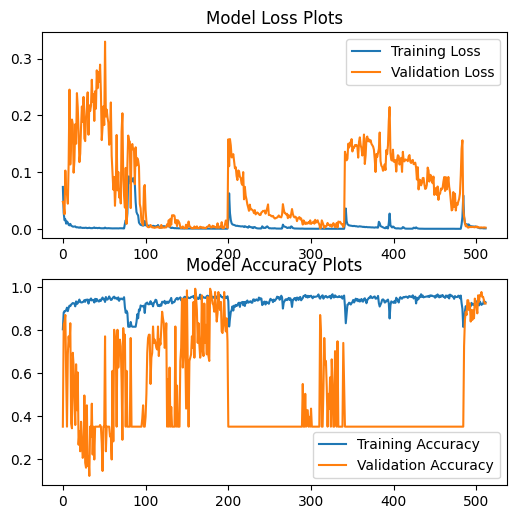

In [800]:
%matplotlib inline

# Build the model architecture
model = Sequential()

model.add(LSTM(units=128, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1:])))
model.add(Dropout(0.7))
model.add(LSTM(units=256, activation='tanh', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=128, activation='tanh', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=len(outputs))) # Prediction of the next value

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

# Get those sweet, sweet checkpoints
checkpoint_filepath = os.path.join('.keras_checkpoints', datetime.datetime.now().strftime("%y%m%d_%H%M%S"), 'epoch_{epoch:04d}.hdf5')
os.makedirs(os.path.dirname(checkpoint_filepath), exist_ok=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
    save_weights_only=True, monitor='val_loss', mode='max', save_best_only=False)

# TODO: Need to figure out how to tune the parameters
history = model.fit(x_train, y_train, epochs=512, batch_size=32, validation_freq=1, validation_split=0.1, callbacks=[checkpoint])
plot_history(history.history)

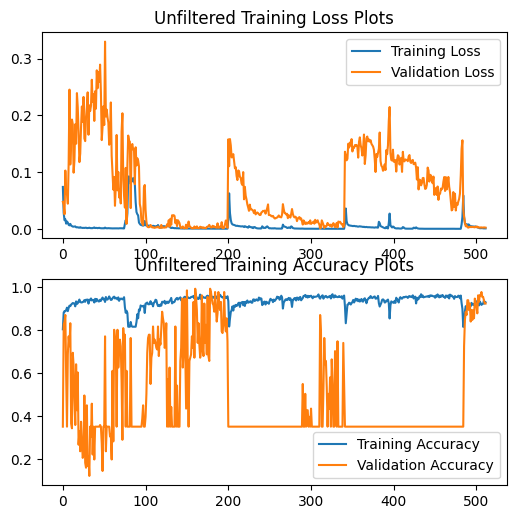

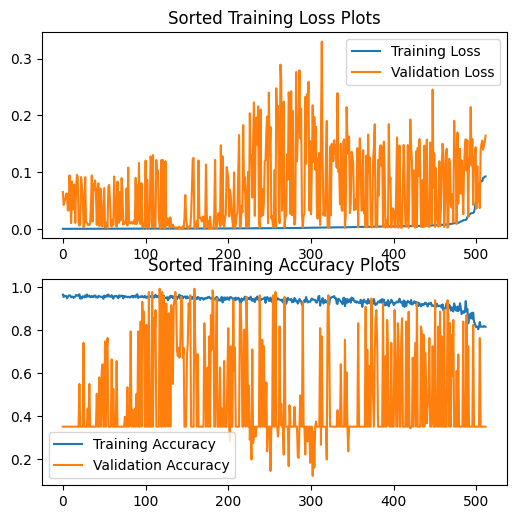

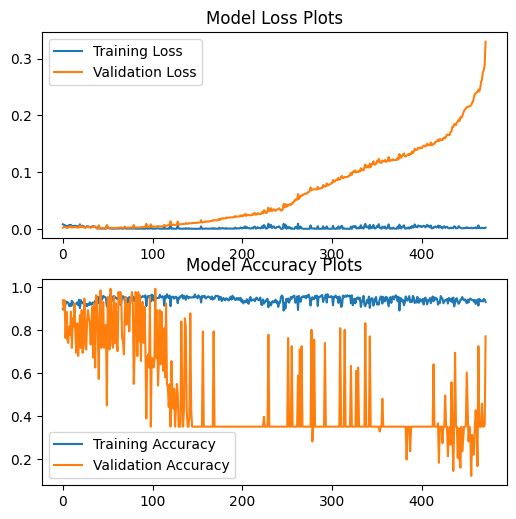

loss               0.008285
accuracy           0.897611
val_loss           0.002451
val_accuracy       0.938931
loss_diff          0.005834
accuracy_diff     -0.041320
epoch            490.000000
Name: 0, dtype: float64

In [822]:
%matplotlib inline

# Let's find the BEST epoch from our model training session
hist = pd.DataFrame(history.history)
hist['loss_diff'] = hist['loss'] - hist['val_loss']
hist['accuracy_diff'] = hist['accuracy'] - hist['val_accuracy']
hist['epoch'] = pd.Series(hist.index)
hist_sorted = hist.sort_values(['loss', 'val_loss'], ascending=True, ignore_index=True)

# Save the history to CSV for use in later analysis
pd.DataFrame(loss).to_csv(os.path.join(os.path.dirname(checkpoint_filepath), '.history.csv'), index_label='index')

# Show the computed results
plot_history(history.history, title='Unfiltered Training')
plot_history(hist_sorted, title='Sorted Training')

hist_sorted = hist_sorted[hist_sorted['loss'] < 0.01].sort_values(['loss_diff'], ascending=False, ignore_index=True)
#hist_sorted = hist_sorted[hist_sorted['accuracy'] > 0.95].sort_values(['accuracy_diff'], ascending=True, ignore_index=True)
plot_history(hist_sorted)
hist_sorted.iloc[0]


In [818]:
# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)

best_epoch = os.path.join(os.path.dirname(checkpoint_filepath), f'epoch_{loss_sorted["epoch"][0]:04d}.hdf5')
#best_epoch = os.path.join(os.path.dirname(checkpoint_filepath), f'epoch_0118.hdf5')

model.load_weights(best_epoch)
print(best_epoch)

.keras_checkpoints\220301_104907\epoch_0124.hdf5


In [819]:
### Test the Model Accuracy on Existing Data ###
################################################

# Build the test data
x_test = []
#len(total_temp)-len(test)-prediction_days
for x in range(window_sample_size, len(scaled_data)-window_sample_size):
    x_test.append(scaled_data[x-window_sample_size:x, :-len(outputs)])
x_test = np.array(x_test)
print('X Test Data Shape: ', x_test.shape)

# Make Predictions on Test Data
pred = model.predict(x_test)
print('Predictions:\n', pred[:][:10])

#np.append(x_test, pred)
#print('X Test Data Shape: ', x_test.shape)
#pred = scaler.inverse_transform(x_test)
#print('Inverse Transformed Predictions\n', pred[:][:10])

#from sklearn.metrics import mean_absolute_error
#mean_absolute_error(test['Avg_Temp'], pred)

X Test Data Shape:  (1159, 144, 17)
Predictions:
 [[ 0.26876482  0.0168772  -0.00991312]
 [ 0.26874062  0.01688552 -0.00984362]
 [ 0.2687165   0.0168994  -0.00979564]
 [ 0.2686919   0.01691937 -0.00977254]
 [ 0.26866645  0.01694537 -0.00976923]
 [ 0.26864016  0.01697774 -0.00978842]
 [ 0.26861128  0.01702069 -0.00983855]
 [ 0.26858732  0.01706468 -0.0099169 ]
 [ 0.26856762  0.01710692 -0.01001495]
 [ 0.26854908  0.017152   -0.01013178]]


<IPython.core.display.Javascript object>


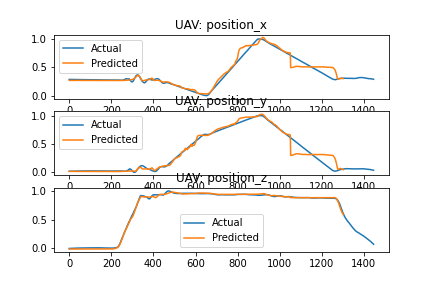

In [820]:
### Visualization ###
#####################
'''
pred_ = pd.DataFrame(test['time'])
pred_['position_x'] = pred
pred_["time"] = pd.to_datetime(pred_["time"])
print(pred_)
original = florida.loc[florida['Date'] >= '1990-01-01']
'''

%matplotlib notebook

import seaborn as sns

for i in list(range(0, len(outputs))):
    ax = plt.subplot(len(outputs), 1, i+1)
    sns.lineplot(x=list(range(0, len(scaled_data))), y=scaled_data[:, -len(outputs)+i])
    sns.lineplot(x=list(range(0, len(pred)+window_sample_size)), y=np.append(np.ones(window_sample_size)*pred[0, i], pred[:, i]))
    ax.set_title(f'UAV: {outputs[i]}')
    ax.legend(['Actual', 'Predicted'])

plt.show()